<a href="https://colab.research.google.com/github/dora-jpg/Vaccine-Sentiment-Classifier/blob/main/AI2_HM3_bidirectional_RNN_with_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Intelligense II - Homework 3
# 💉Vaccine sentiment classifier using bidirectional Recursive Neural Networks. I experimented with LSTM and GRU

In this exercise we are going to develop a vaccine sentiment classifier that classifies tweets in pro-vax, anti-vax and neutral classes using bidirectional Recursive Neural Networks. I experimented with LSTM and GRU.
For data preprocessing and feature extracting I experimented with:
- GloVe pretrained model: I used a simple preprocessing funtion that removes puctuation, html tags and urls. I kept emojis because I noticed that some of them are included in the pretrained glove model. I used the glove.twitter.27B.50d. 
- TF-IDF: I used the same preprocessing as for GloVe. 


**Note:** 
- I seeded numpy.random and torch.random in the cells that define each model so that I get the same results in every run and can compare scores.
- I couldn't try a bigger GloVe pretrained model because of my internet connection.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries and Read Datasets

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

import numpy as np
import pandas as pd

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

# Evaluation metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# import torchvision
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random
import sys
from IPython.display import Image



def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

device = 'cpu'
print('Working on:', device)

Working on: cpu


Read train and validation datasets.

In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/vaccine_train_set.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/vaccine_validation_set.csv")

 We don't need the first column of the datasets because it is an index.

In [4]:
# get rid of first column
df_train = df_train.iloc[: , 1:]
df_test = df_test.iloc[: , 1:]

In [5]:
display(df_train.head())
display(df_train.describe())
display(df_train.info())

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


,label
count,15976.000000
mean,0.936592
std,0.930740
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15976 entries, 0 to 15975
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   15976 non-null  object
 1   label   15976 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 249.8+ KB


None

In [6]:
display(df_test.head())
display(df_test.describe())
display(df_test.info())

,tweet,label
0,@user They had a massive surge in with covid d...,1
1,Required vaccines for school: Parents and guar...,0
2,“@KCStar: Two more Johnson County children hav...,0
3,NV can do better. Which states are the best (a...,2
4,Nothing like killing ourselves w/ our own fear...,2


,label
count,2282.000000
mean,0.936897
std,0.930960
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282 entries, 0 to 2281
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   2282 non-null   object
 1   label   2282 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.8+ KB


None

## Data Pre-processing

### Data Cleaning


In [7]:
#Check for null values
#In this case there are no missing values, so no action is needed
df_train.isnull().sum()

tweet    0
label    0
dtype: int64

In [8]:
df_test.isnull().sum()

tweet    0
label    0
dtype: int64

In [9]:
import re
import string
from nltk.corpus import stopwords

import nltk
nltk.download("stopwords")

stop_words = stopwords.words("english")

def tweets_cleaning(x, remove_emojis=False, remove_stop_words=True):
    """Apply function to a clean a tweet"""
    x = x.lower().strip()
    # romove urls
    url = re.compile(r'https?://\S+|www\.\S+')
    x = url.sub(r'',x)
    # remove html tags
    html = re.compile(r'<.*?>')
    x = html.sub(r'',x)
    # remove punctuation
    operator = str.maketrans(' ',' ',string.punctuation)
    x = x.translate(operator)
    if remove_emojis:
        x = x.encode('ascii', 'ignore').decode('utf8').strip()
    if remove_stop_words:
        x = ' '.join([word for word in x.split(' ') if word not in stop_words])
    return x

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
## APPLY the cleaning function to the text column
df_train['cleanglove_tweet'] = df_train['tweet'].apply(tweets_cleaning)
df_test['cleanglove_tweet'] = df_test['tweet'].apply(tweets_cleaning)

In [11]:
Y_train = df_train['label'] #Only keep value
Y_test = df_test['label'] #Only keep value

In [12]:
df_train['cleanglove_tweet']

0        sip n shop come thru right marjais popularnobo...
1        dont know family take covid19 vaccine anytime ...
2        msignorile immunizations mandatory period okla...
3        president obama spoke favor vaccination childr...
4        myfoxla arizona monitoring hundreds measles li...
                               ...                        
15971    salon u believe antivax nutcases caused measle...
15972    feel parents dont vaccinate kids\r\n\r\nmeasle...
15973          70 preschoolers tested measles simi valley 
15974    finance minister budget offers room procure co...
15975    date vaccines take cdc’s vaccine quiz find vac...
Name: cleanglove_tweet, Length: 15976, dtype: object

In [13]:
df_train['cleanglove_tweet']

0        sip n shop come thru right marjais popularnobo...
1        dont know family take covid19 vaccine anytime ...
2        msignorile immunizations mandatory period okla...
3        president obama spoke favor vaccination childr...
4        myfoxla arizona monitoring hundreds measles li...
                               ...                        
15971    salon u believe antivax nutcases caused measle...
15972    feel parents dont vaccinate kids\r\n\r\nmeasle...
15973          70 preschoolers tested measles simi valley 
15974    finance minister budget offers room procure co...
15975    date vaccines take cdc’s vaccine quiz find vac...
Name: cleanglove_tweet, Length: 15976, dtype: object

Overview of label distribution

In [14]:
print("train data")
print("label 0:",Y_train[Y_train== 0].count())
print("label 1:",Y_train[Y_train== 1].count())
print("label 2:",Y_train[Y_train== 2].count())
print("validation data")
print("label 0:",Y_test[Y_test== 0].count())
print("label 1:",Y_test[Y_test== 1].count())
print("label 2:",Y_test[Y_test== 2].count())

train data
label 0: 7458
label 1: 2073
label 2: 6445
validation data
label 0: 1065
label 1: 296
label 2: 921


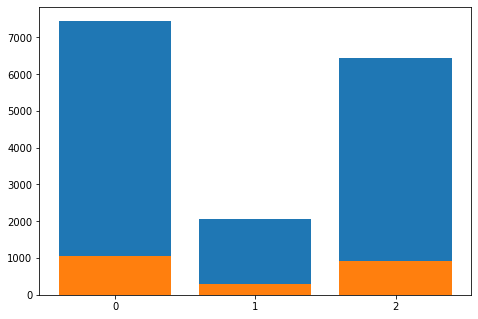

In [15]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['0', '1', '2']
students = [Y_train[Y_train== 0].count(),Y_train[Y_train== 1].count(),Y_train[Y_train== 2].count()]
students2= [Y_test[Y_test== 0].count(),Y_test[Y_test== 1].count(),Y_test[Y_test== 2].count()]
ax.bar(langs, students)
ax.bar(langs, students2)
plt.show()

Label 1 has very few instances so we expect that it has a lower score than the other 2 labels. 

## Features Extraction


### GloVe representation

Load pre-trained GloVe vectors into a dictionary.

In [16]:
embeddings_dict = {}
with open("/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/glove.twitter.27B.50d.txt", 'r', encoding="utf-8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    embeddings_dict[word]=vector

Find the vector for each word in each tweet and for every tweet keep the average of each dimesion of its words.

Some words do not exist in the pretrained model and in some tweets there isn't any word that matches. So I filled those tweets with zeros.  

In [17]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize
def find_glove(text):
  tokens = word_tokenize(text.lower())
  res = [ embeddings_dict[token] for token in tokens if (token in embeddings_dict) ]
  # print([ token for token in tokens if (token not in embeddings_dict) ] )
  if (len(res) == 0):
    res = np.zeros(50)
  else:
    res = np.stack(res, axis=0)
    res = np.average(res, axis=0).flatten()
  return res

df_train['features'] = df_train['cleanglove_tweet'].apply(find_glove)
df_test['features'] = df_test['cleanglove_tweet'].apply(find_glove)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### TF-IDF representation

Apply the simple preprocessing to the tf-idf's tweets.

In [18]:

df_train['cleantfidf_tweet'] = df_train['tweet'].apply(tweets_cleaning)
df_test['cleantfidf_tweet'] = df_test['tweet'].apply(tweets_cleaning)

For the TF-IDF vectorization I used unigrams & bigrams for a better representation of the tweets and connections between words. I tried 0.01, 0.002 and 0.001 for the min_df parameter. 0.01 resulted in very little features that were not enough to represent the dataset well. 0.002 is the value that I worked best in Homework 1, but 0.001 did better in this one.

In [19]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=0.001, stop_words='english', lowercase=True)

tfidf_vectorizer.fit(df_train['cleantfidf_tweet'])

tfidf_train = tfidf_vectorizer.transform(df_train['cleantfidf_tweet'])
print(tfidf_train.shape)
print(tfidf_vectorizer.get_feature_names_out())
tfidf_test = tfidf_vectorizer.transform(df_test['cleantfidf_tweet'])
print(tfidf_test.shape)

(15976, 1900)
['10' '100' '1000' ... 'yr' 'yrs' 'zero']
(2282, 1900)


## Bidirectional RNN with LSTM/GRU